In [1]:
import os
#os.environ["TF_NUM_INTEROP_THREADS"] = "1"
#os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
#os.environ["OMP_NUM_THREADS"] = "4"
#os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
#os.environ["KMP_BLOCKTIME"] = "0"
#os.environ["TF_ENABLE_ONEDNN_OPTS"]="1"
import tensorflow as tf
print(tf.__version__)

2023-02-13 06:57:55.991535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [3]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [4]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


In [5]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

<b><font size =5>Prepare the data</font></b>

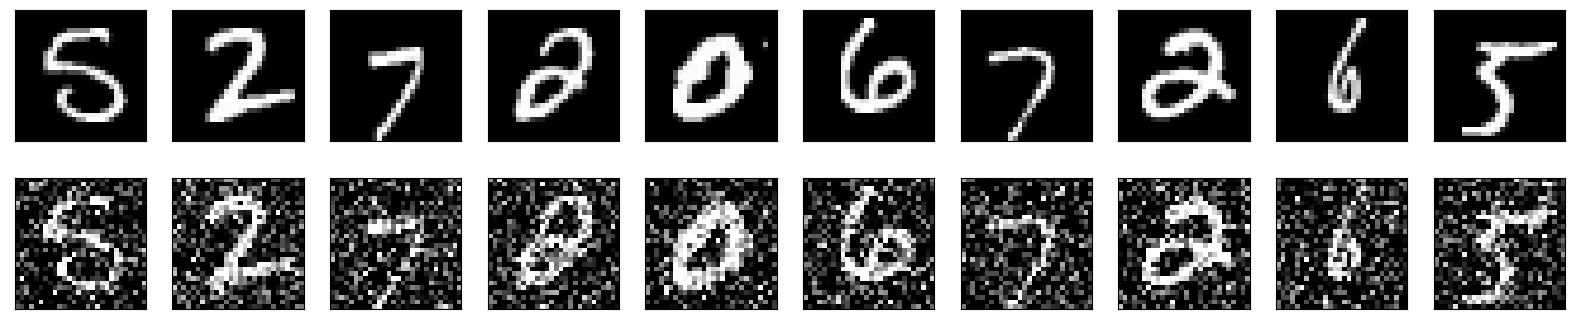

In [6]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

<b><font size = 5>Build the autoencoder</font></b>\
<font size =3>We are going to use the Functional API to build our convolutional autoencoder.</font>

In [7]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2023-02-13 06:58:58.605905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

<font size =3>Now we can train our autoencoder using train_data as both our input data and target. Notice we are setting up the validation data using the same format.</font>

In [8]:
import time
start_time = time.time()
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)
print("training time", time.time() - start_time)

Epoch 1/10
469/469 [==============================] - 27s 52ms/step - loss: 0.1264 - val_loss: 0.0730
Epoch 2/10
469/469 [==============================] - 24s 52ms/step - loss: 0.0714 - val_loss: 0.0693
Epoch 3/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0691 - val_loss: 0.0681
Epoch 4/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0680 - val_loss: 0.0671
Epoch 5/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0672 - val_loss: 0.0663
Epoch 6/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0666 - val_loss: 0.0659
Epoch 7/10
469/469 [==============================] - 24s 50ms/step - loss: 0.0661 - val_loss: 0.0654
Epoch 8/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0657 - val_loss: 0.0651
Epoch 9/10
469/469 [==============================] - 24s 50ms/step - loss: 0.0654 - val_loss: 0.0648
Epoch 10/10
469/469 [==============================] - 23s 49ms/step - loss: 0.065

<font size =3>Let's predict on our test dataset and display the original image together with the prediction from our autoencoder.</font>

313/313 [==============================] - 3s 9ms/step


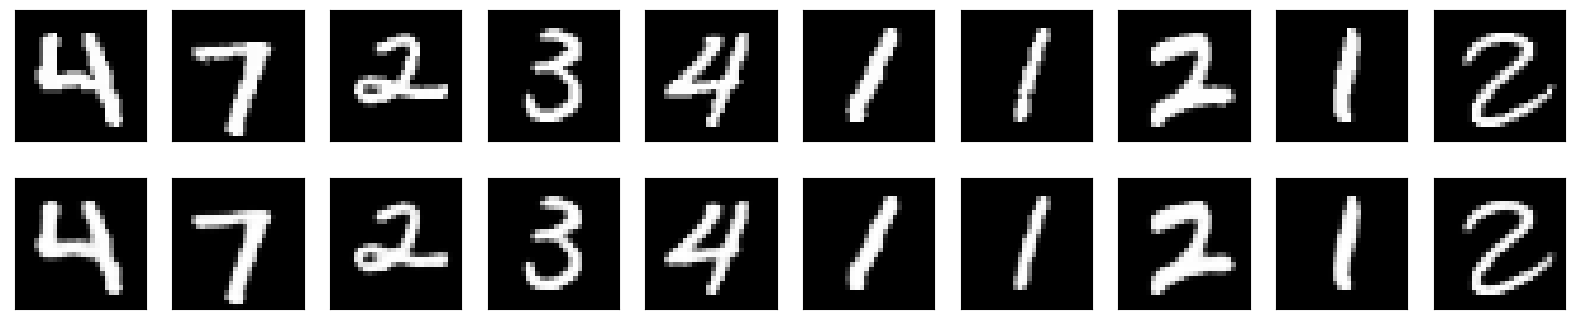

In [9]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

<font size =3>Now that we know that our autoencoder works, let's retrain it using the noisy data as our input and the clean data as our target. We want our autoencoder to learn how to denoise the images.</font>

In [10]:
import time
start_time = time.time()
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)
print("training time", time.time() - start_time)

Epoch 1/10
469/469 [==============================] - 24s 50ms/step - loss: 0.1022 - val_loss: 0.0943
Epoch 2/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0938 - val_loss: 0.0918
Epoch 3/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0918 - val_loss: 0.0903
Epoch 4/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0906 - val_loss: 0.0895
Epoch 5/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0898 - val_loss: 0.0889
Epoch 6/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0892 - val_loss: 0.0882
Epoch 7/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0887 - val_loss: 0.0877
Epoch 8/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0882 - val_loss: 0.0874
Epoch 9/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0879 - val_loss: 0.0870
Epoch 10/10
469/469 [==============================] - 24s 50ms/step - loss: 0.087

<font size = 3>Let's now predict on the noisy data and display the results of our autoencoder.</font>

<font size = 3>Notice how the autoencoder does an amazing job at removing the noise from the input images.</font>

313/313 [==============================] - 3s 9ms/step


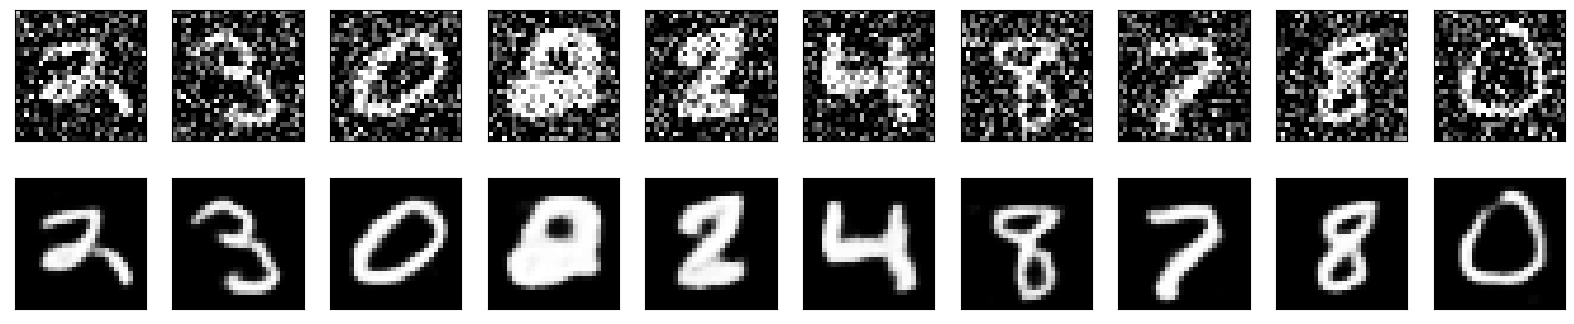

In [11]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)